In this notebook we investigate if the 4th of July is the loudest holiday of the year. To do this we are going to look at [311 noise complaints](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) from the New York Open Data Portal. 

First we import the necessary libraries we are going to need. 

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from fbprophet import Prophet
from datetime import datetime
%matplotlib inline

We have already downloaded the data in CSV format to a file called '311_calls.csv' you can grab that file by downloading it manually or running 

```python
from urllib.request import urlretrieve
urlretrive('https://nycopendata.socrata.com/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD', '311_calls.csv')
```

please note however it's a pretty big file (12Gb at the time of writing). Let's take a quick look at the first 5 rows.

In [2]:
first_five = pd.read_csv('311_calls.csv',nrows=5)
first_five

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,40689872,10/29/2018 03:55:11 PM,10/31/2018 09:28:25 PM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10458,396 EAST 199 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.867005,-73.884611,"(40.86700508050965, -73.88461099356945)"
1,40689874,10/29/2018 01:54:59 PM,10/31/2018 02:05:38 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,11210,2720 FOSTER AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.638459,-73.950871,"(40.63845895646158, -73.95087137476301)"
2,41595566,01/30/2019 05:53:27 PM,02/03/2019 02:06:46 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,11373,88-35 ELMHURST AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.746372,-73.877461,"(40.746372482461695, -73.87746125315917)"
3,37438112,10/16/2017 12:00:00 AM,10/18/2017 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,3+ Family Mixed Use Building,11228,910 81 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.621895,-74.019240,"(40.62189480621294, -74.01923952021282)"
4,39333279,05/31/2018 10:01:00 AM,05/31/2018 12:00:00 PM,DSNY,BCC - Brooklyn North,Derelict Vehicles,14 Derelict Vehicles,Street,11221,143 WOODBINE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.692509,-73.916772,"(40.69250873618191, -73.91677242709606)"


In [3]:
first_five.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

There is a lot of rich data in there but we won’t need it all. Instead let's limit the columns we are bringing in to 
- Complaint Type
- Created Date 
- Descriptor 
- Borough
- Latitude
- Longitude

While not strictly necessary here, let's also load the data in chunks. This can be helpful if we want to do any filtering as we go, for example, dropping anything without a descriptor or a complaint type. When reading in big files using pandas, this lets us avoid blowing up our memory requirements.


In [4]:
cols = ['Complaint Type', 'Created Date','Descriptor','Borough','Latitude','Longitude']

In [5]:
all_data = pd.DataFrame()
for index, chunk in enumerate(pd.read_csv('311_calls.csv', usecols=cols, chunksize=100000)):
    chunk  = chunk.dropna(subset=['Descriptor', 'Complaint Type'], how='all')
    all_data = all_data.append(chunk)
    

This will take a few moments to read in but then we should have all the 311 data we will need. 

We have over 21 million calls in there! New Yorkers complain a lot! 

Let’s look at the types of complaints that tend to come up.

In [6]:
all_data['Complaint Type'].value_counts().head(20)

Noise - Residential              1691189
HEAT/HOT WATER                   1146190
Street Condition                  926939
HEATING                           887869
Street Light Condition            881944
Blocked Driveway                  849098
Illegal Parking                   808416
PLUMBING                          698569
Water System                      612249
GENERAL CONSTRUCTION              500863
General Construction/Plumbing     475512
Noise                             455550
UNSANITARY CONDITION              427586
Noise - Street/Sidewalk           414678
Traffic Signal Condition          414610
PAINT - PLASTER                   361258
Sewer                             345937
PAINT/PLASTER                     338392
Dirty Conditions                  332207
Noise - Commercial                331256
Name: Complaint Type, dtype: int64

In [7]:
all_data[all_data['Complaint Type'].str.contains("Noise")]['Complaint Type'].value_counts()

Noise - Residential         1691189
Noise                        455550
Noise - Street/Sidewalk      414678
Noise - Commercial           331256
Noise - Vehicle              195395
Noise - Park                  33175
Noise Survey                  16303
Noise - Helicopter             9979
Noise - House of Worship       9338
Collection Truck Noise         1706
Name: Complaint Type, dtype: int64

As we can see there are quite a few top level complaint types that indicate noise. Let's dig in to one in more detail, specifically the "Noise - Commercial" type 

In [8]:
all_data[all_data['Complaint Type']=='Noise - Commercial'].Descriptor.value_counts()

Loud Music/Party    252204
Banging/Pounding     34679
Loud Talking         30052
Car/Truck Music       7474
Car/Truck Horn        6144
Loud Television        703
Name: Descriptor, dtype: int64

While some of these are relevant to our question, some like 'Banging/Pounding" probably aren't. So let's narrow it down to calls with a complaint type which is one of 

- 'Noise - Residential', 
- 'Noise Survey',
- 'Noise - Park',
- 'Noise - Street/Sidewalk'

or has a descriptor of 

- 'Car/Truck Music'
- 'Car/Truck Horn'
- 'Loud Music/Party'

In [9]:
cleaned = all_data[
    all_data['Complaint Type'].isin([
        'Noise - Residential', 
        'Noise Survey',
        'Noise - Park',
        'Noise - Street/Sidewalk'
    ]) | 
    all_data['Descriptor'].isin(['Car/Truck Music','Car/Truck Horn','Loud Music/Party']) 
]

In [10]:
cleaned.shape

(2573188, 6)

That still leaves us with 2,573,188 calls! Next let's format the date to be a proper python datetime

In [22]:
cleaned = cleaned.assign(date = pd.to_datetime(cleaned['Created Date'], format='%m/%d/%Y %I:%M:%S %p'))

Now that we have the data in a good format, we can plot a time series of number of calls per day to see if we can spot any trends around holidays. We will add a red line indicating the 4th of July for each year 


Text(0,0.5,'Calls per day')

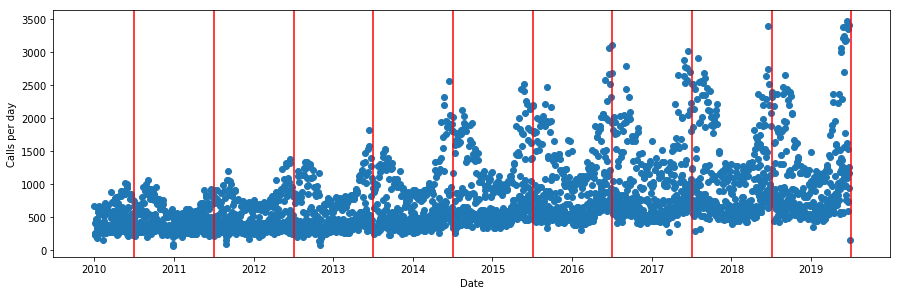

In [23]:
trend = cleaned.groupby(cleaned.date.dt.floor('d')).count()[['Descriptor']]

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.scatter(trend.index,trend.Descriptor)
for year in range(2010,2020):
    plt.axvline(datetime(year,7,4), color='red')
plt.xlabel("Date")
plt.ylabel('Calls per day')

There seems to be a few things going on here: 
- First we see an overall trend of increased call volume each year. 
- Second, there tends to be more calls in the summer 
- Third, it looks like there are two trends superimposed over each other

This all makes it hard to figure out what is going on and to tell if there is much of a difference in call volume on the 4th of July. 

We might guess that there is a different behavior on the weekends and weekdays. Let's plot the same chart again but with weekdays in blue and weekends in green

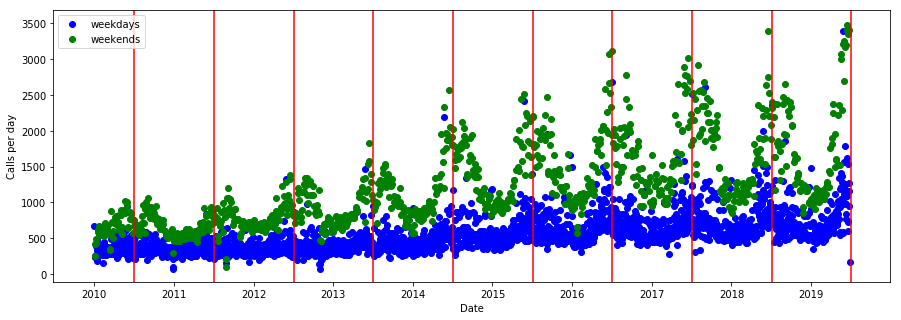

In [24]:
weekdays = (pd.DatetimeIndex(trend.index).dayofweek) < 5 
friday = (pd.DatetimeIndex(trend.index).dayofweek == 4)

plt.figure(figsize=(15,5))
plt.scatter(trend[weekdays].index,trend[weekdays].Descriptor,color='blue',label='weekdays')
plt.scatter(trend[~weekdays].index,trend[~weekdays].Descriptor,color='green', label='weekends')
# plt.scatter(trend[friday].index,trend[friday].Descriptor,color='orange', label='fridays')

for year in range(2010,2020):
    plt.axvline(datetime(year,7,4), color='red')
plt.xlabel('Date')
plt.ylabel('Calls per day')
plt.legend()

It's pretty obvious that there is very different behavior on the weekends as opposed to the weekdays. 

Let's also take a look at the hourly variations for different days of the week.

Text(0,0.5,'Average calls per hour')

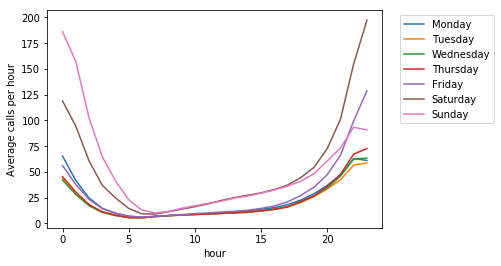

In [25]:
(cleaned.groupby([cleaned.date.dt.weekday_name,cleaned.date.dt.hour]
).count()
 .rename_axis(['Day Of Week','hour'])
 .reset_index()
 .pivot_table(index='hour', columns='Day Of Week', values='Longitude')
 .div(495,axis=1)

 [["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday",'Sunday']]
 .plot().legend(bbox_to_anchor=(1.35, 1)))

plt.ylabel("Average calls per hour")

It looks like there is a contiouious peak of calls in the evenings of most days that carries over in to the early hours of the next morning. If someone called to complain about noise at 2am on a Sunday morning, we would probably more naturally describe that disruption as having occured on Satuarday night. To take account of this, we can simply shift the call times by 4 hours to more naturally attribute them to the correct day. If we do so, the hourly pattern looks more like the following:

In [26]:
cleaned = cleaned.assign( date_minus_4 = cleaned.date  - pd.Timedelta(hours=5) )

Text(0,0.5,'Average calls per hour')

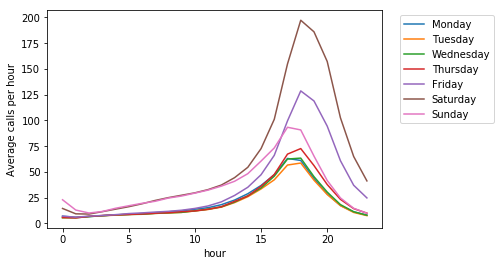

In [27]:
(cleaned.groupby([cleaned.date_minus_4.dt.weekday_name,cleaned.date_minus_4.dt.hour]
).count()
 .rename_axis(['Day Of Week','hour'])
 .reset_index()
 .pivot_table(index='hour', columns='Day Of Week', values='Longitude')
 .div(495,axis=1)

 [["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday",'Sunday']]
 .plot().legend(bbox_to_anchor=(1.35, 1)))

plt.ylabel("Average calls per hour")

If the 4th of July happened to fall on a weekend one year, we wouldn't be able to tell if the number of calls are higher because it's the 4th or because it's a weekend. We need a way to separate out how different components impact the number of calls.

To do that we need to build an additive model with components for 

- The day of the year 
- The overall trend 
- The day of the week 
- If there is a holiday on that day 

Thankfully, there is a pretty good library from facebook that will help us with this called Prophet. 

Let's load it up and make a quick model with those components

In [29]:
holidays=['Christmas Day',
 'Columbus Day',
 'Independence Day',
 'Labor Day',
 'Memorial Day',
 'Martin Luther King, Jr. Day',
 "New Year's Day",
 'Thanksgiving',
 'Veterans Day',
 "Washington's Birthday",
]


new_years_eve = pd.DataFrame({
    'holiday': 'New Years Eve',
    'ds' : pd.to_datetime( [ '{}-12-31'.format(year) for year in range(2010,2020)]),
    'lower_window' : 0,
    'upper_window' : 1
})

halloween = pd.DataFrame({
    'holiday': 'Halloween',
    'ds' : pd.to_datetime( [ '{}-10-31'.format(year) for year in range(2010,2020)]),
    'lower_window' : 0,
    'upper_window' : 1
})

extra_holidays = pd.concat((halloween,new_years_eve))

trend = cleaned.groupby(cleaned.date_minus_4.dt.floor('d')).count()[['Descriptor']]

m = Prophet(mcmc_samples = 300, seasonality_mode='multiplicative',holidays=extra_holidays)
m.add_country_holidays(country_name='US')
m.fit(trend.reset_index().rename(columns={'date_minus_4':'ds','Descriptor':'y'}))
forecast = m.predict()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The above code adds features to the model for various US holidays and then tries to fit that model to our data. Note this can take awhile, if you are just interested in point estimates of the model, you can rerun this without the mcmc_samples argument and it will be much faster. 

We can plot the predictions of the model and compare with our data as follows:

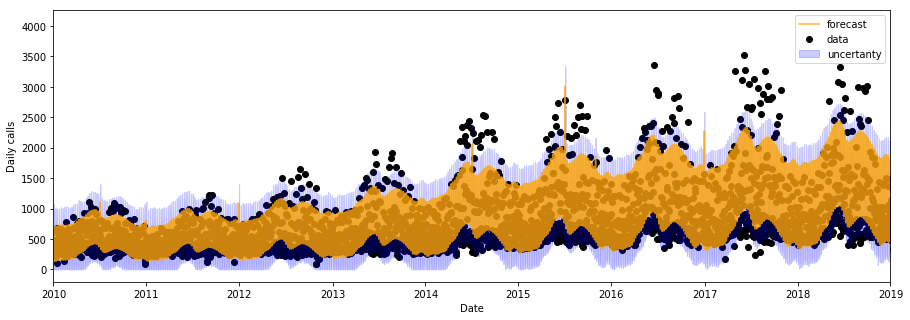

In [30]:
plt.figure(figsize=(15,5))
plt.scatter(trend.index,trend.Descriptor, alpha=1, label='data',color='black')
plt.fill_between(forecast.ds, np.clip(forecast.yhat_lower,0, None), forecast.yhat_upper, alpha=0.2, color='blue',label='uncertanty')

plt.plot(forecast.ds,forecast.yhat,alpha=0.8, label='forecast',color='orange')
plt.xlim(datetime(2010,1,1),datetime(2019,1,1))
plt.ylabel('Daily calls')
plt.xlabel('Date')
plt.legend();

The model does ok at capturing the trends we see, but could probably be improved. We are just doing this for fun so let's leave tuning the model for another time and simply look at the different components of fit model

Text(44.375,0.5,'Day of Year Factor')

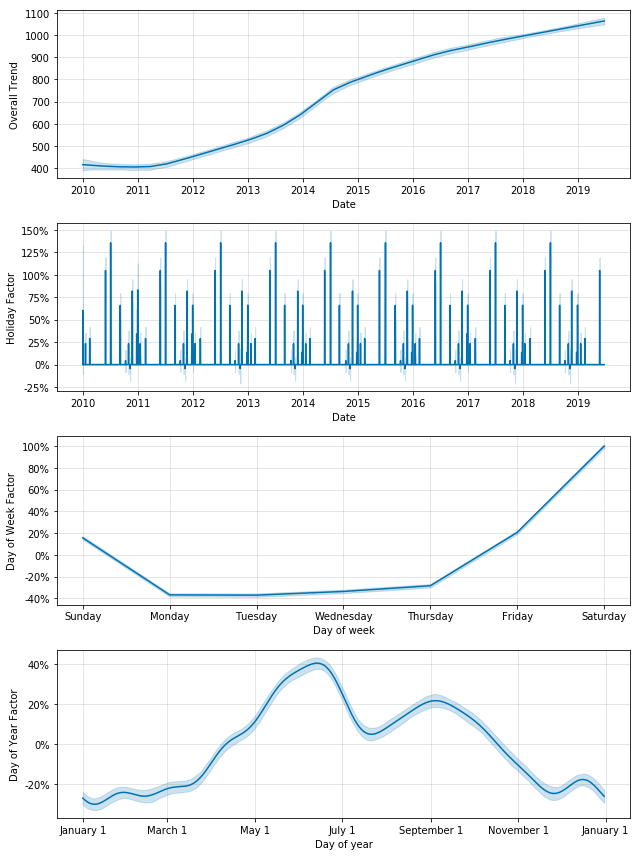

In [31]:
fig = m.plot_components(forecast);
fig.axes[0].set_ylabel('Overall Trend')
fig.axes[0].set_xlabel("Date")
fig.axes[1].set_ylabel('Holiday Factor')
fig.axes[1].set_xlabel("Date")

fig.axes[2].set_ylabel('Day of Week Factor')
fig.axes[3].set_ylabel('Day of Year Factor')


We see some interesting features here

- The model confirms our intuition that weekends tend to have a larger call volume than weekdays, in fact weekends tend to have roughly 500 more calls than average while weekdays have 200 fewer calls 
- There is a huge seasonality to call volume with summer having a lot more calls than winter 
- There are two peaks during the year for calls, one is around mid-may and the other around the start of september 
- We also see some significant effects from holidays

Let's redo the holiday plot but highlight the 4th of July and a few of the other significant holidays


In [32]:
forecast[ [col for col in forecast.columns if 'King' in col] ].drop_duplicates()

,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day_lower","Martin Luther King, Jr. Day_upper"
0,0.000000,0.000000,0.000000
18,0.232911,0.098201,0.355423


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


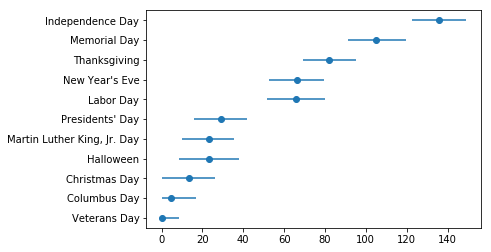

In [36]:
def show_holiday_factors(df,ax=None, holidays= holidays):
    everything = pd.DataFrame()
    if(ax == None):
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for holiday in holidays:
        val = df[holiday].max()
        upper = df[holiday + '_upper'].max()
        lower = df[holiday + '_lower'].max()
        everything = everything.append({'holiday': holiday, 'val' : val, 'upper': upper, 'lower': lower}, ignore_index='True')
    everything = everything.sort_values(by='val')
    ax.scatter(everything.val*100, range(everything.shape[0]))
    ax.errorbar(x=everything.val*100 , y = everything.holiday, xerr= everything[['lower','upper']].sub(everything.val,axis=0).abs().as_matrix().T*100,ls='none')


filtered_holidays = ['Christmas Day',
 'Columbus Day',
 'Independence Day',
 'Labor Day',
 'Memorial Day',
 'Martin Luther King, Jr. Day',
 "Halloween",
 "New Year's Eve",
 'Thanksgiving',
 'Veterans Day',
 "Presidents' Day"]

show_holiday_factors(forecast.rename(columns = { "Washington's Birthday" : "Presidents' Day", 
                                 "Washington's Birthday_lower": "Presidents' Day_lower", 
                                 "Washington's Birthday_upper": "Presidents' Day_upper",
                                 "New Years Eve" : "New Year's Eve", 
                                 "New Years Eve_upper" : "New Year's Eve_upper", 
                                 "New Years Eve_lower" : "New Year's Eve_lower", 
                                }).drop(["New Year's Day",
       "New Year's Day_lower", "New Year's Day_upper",
       "New Year's Day (Observed)", "New Year's Day (Observed)_lower",
       "New Year's Day (Observed)_upper"],axis=1), holidays= filtered_holidays)

## By borough

We can also break this out by borough to see what kind of trends we see in each part of the city. We simple slice the data by borough and fit a model to each.

In [39]:
trend_boroughs = cleaned.groupby([cleaned.date_minus_4.dt.floor('d'),'Borough']).count()[['Descriptor']].reset_index()

In [40]:
trend_boroughs.head()

,date_minus_4,Borough,Descriptor
0,2009-12-31,BRONX,60
1,2009-12-31,BROOKLYN,77
2,2009-12-31,MANHATTAN,49
3,2009-12-31,QUEENS,54
4,2009-12-31,STATEN ISLAND,8


In [41]:
forecasts = {}
models = {}
for borough, data in trend_boroughs.groupby('Borough'):
    m = Prophet(mcmc_samples = 300)
    m.add_country_holidays(country_name='US')
    m.fit(data.rename(columns={'date_minus_4':'ds','Descriptor':'y'}))
    models[borough] = m 
    forecasts[borough] = m.predict()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
forecasts.keys()

dict_keys(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Unspecified'])

Now we can compare the different model components with each other to see how boroughs differ.

In [43]:
all_boroughs  = pd.DataFrame()
for borough in models.keys():
    f= forecasts[borough]
    all_boroughs[borough] = f[f[holidays].abs().any(axis=1) > 0][holidays].drop_duplicates().max()

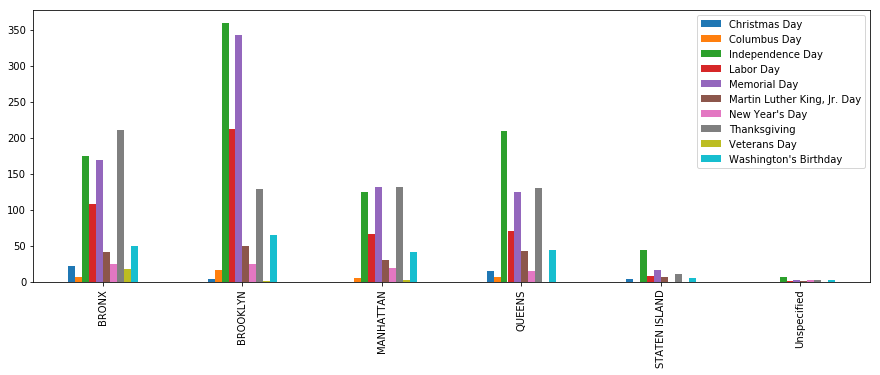

In [44]:
all_boroughs.T.plot(kind='bar',figsize=(15,5))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


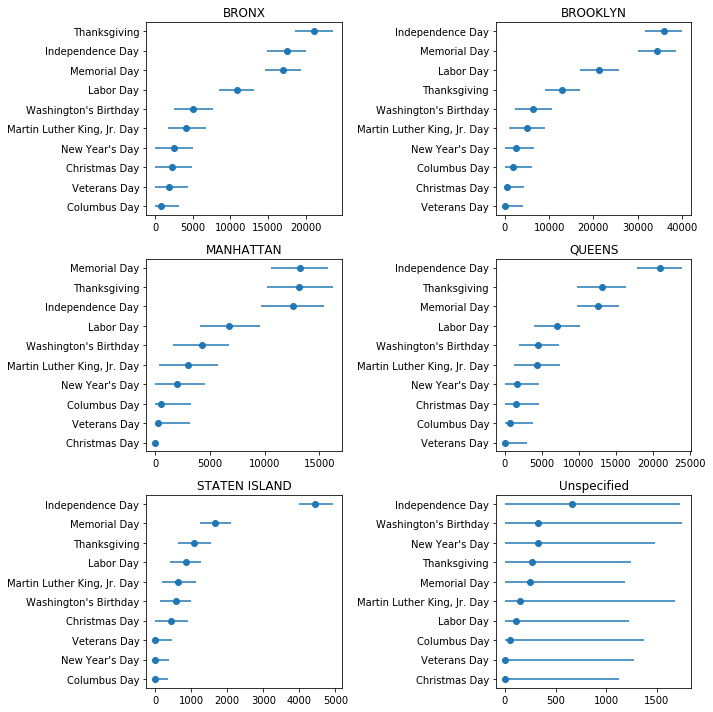

In [45]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax=ax.flatten()
for index,borough in enumerate(models.keys()):
    show_holiday_factors(forecasts[borough],ax=ax[index])
    ax[index].set_title(borough)
plt.tight_layout()


It looks like the following are the most complained about holidays for each borough:

- Manhattan: Memorial Day, New Years Day
- Brooklyn: Labor Day, Memorial Day
- Bonx: Memorial Day, Labor Day
- Queens: Independence Day, Memorial Day 
- Staten Island: Independence Day, Memorial Day


In [46]:
from fbprophet.plot import plot_weekly,plot_yearly

Text(0.5,0,'Day')

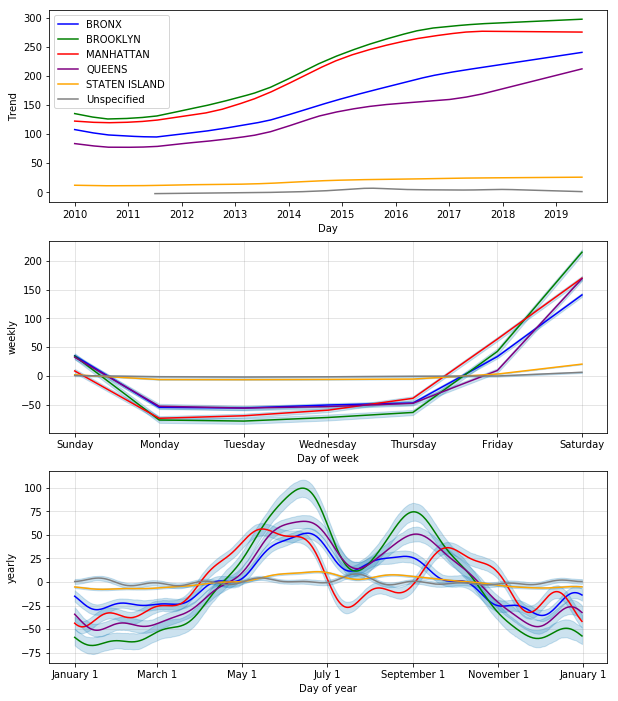

In [47]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,12))

colors={
    "MANHATTAN" : 'red',
    "BRONX": 'blue',
    'QUEENS': 'purple',
    'BROOKLYN': 'green',
    'STATEN ISLAND': 'orange',
    'Unspecified': 'gray'
}
for borough in models.keys():
    forecast_borough = forecasts[borough]
    model_borough = models[borough]
    ax[0].plot(forecast_borough.ds, forecast_borough.trend, label=borough,color=colors[borough])
    ax[0].legend()
    
    a=plot_weekly(model_borough, ax=ax[1])
    a[0].set_color(colors[borough])
    a= plot_yearly(model_borough, ax=ax[2])
    a[0].set_color(colors[borough])
    
ax[0].set_ylabel('Trend')
ax[0].set_xlabel("Day")


It's interesting to see that weekly trends are pretty similar but seasonal trends vary by borough. 

So there we have it, New Yorkers and the holidays most complain about for noise using open data and open source tools!